# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader
import glob

from torchvision import datasets, transforms
from src.models import train_model, model, vanilla_model

from src.features import utils
import pathlib
import PIL
from torchvision.transforms import ToTensor, ToPILImage

from imageaugment import augment
import PIL.Image
import pathlib
import json

# Load MNIST

In [2]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data/raw/', train=True, transform=transforms.ToTensor()), batch_size=128, shuffle=True)

In [3]:
val_loader = torch.utils.data.DataLoader(datasets.MNIST('../data/raw/', train=False, transform=transforms.ToTensor()), batch_size=32, shuffle=True)

## Get Mean & STD of the MNIST Data

In [15]:
dataset = datasets.MNIST('../../DivNoising/examples/data')
mean = 0.
std = 0.
for image, _ in dataset:
    mean += np.array(image).mean()
    std += np.array(image).std()

data_mean /= len(dataset)
data_std /= len(dataset)

# Load Simulated Patches

In [2]:
def load_patches(image_folder_path):
    image_path_list = sorted(image_folder_path.rglob("*.png"))
    images = []

    for _, image_path in enumerate(image_path_list):
        image = PIL.Image.open(image_path)
        image = image.resize((2400, 3500))
        image = image.convert("L")
        x = ToTensor()(image)

        kh, kw = 192, 128  # kernel size
        dh, dw = 192, 128 # stride
        # Pad to multiples of given number
        w_pad1 = (kw - (x.size(2)%kw)) // 2
        w_pad2 = (kw - (x.size(2)%kw)) - w_pad1
        h_pad1 = (kh - (x.size(1)%kh)) // 2
        h_pad2 = (kh - (x.size(1)%kh)) - h_pad1
        x = F.pad(x, (w_pad1, w_pad2, h_pad1, h_pad2), value=1)

        patches = x.unfold(1, kh, dh).unfold(2, kw, dw)
        patches = patches.contiguous().view(-1, kh, kw)
        images.append(patches)

    patched_image_tensors = torch.stack(images)
    patched_images = patched_image_tensors.view(-1, 1, patched_image_tensors.size(2), patched_image_tensors.size(3))
    
    return patched_images

## Load Training Data

In [3]:
clean_image_folder_train = pathlib.Path("/home/fahad/training_data_with_bbox/train/documents/")
patched_training_clean_images = load_patches(image_folder_path=clean_image_folder_train)

noisy_image_folder_train = pathlib.Path("/home/fahad/master_thesis/data/simulated_noisy_templates/train/")
patched_training_noisy_images = load_patches(image_folder_path=noisy_image_folder_train)

patched_training_clean_images.shape
patched_training_noisy_images.shape

torch.Size([142595, 1, 192, 128])

## Load Test Data

In [13]:
clean_image_folder_test = pathlib.Path("/home/fahad/training_data_with_bbox/val/documents/")
patched_test_clean_images = load_patches(image_folder_path=clean_image_folder_test)

noisy_image_folder_test = pathlib.Path("/home/fahad/master_thesis/data/simulated_noisy_templates/val/")
patched_test_noisy_images = load_patches(image_folder_path=noisy_image_folder_test)

patched_test_clean_images.shape
patched_test_noisy_images.shape

torch.Size([43320, 1, 192, 128])

## Load Crops

In [ ]:
def load_crops(crops_folder_path):
    crops_path_list = sorted(crops_folder_path.rglob("*.png"))

    crops = [ToTensor()(PIL.Image.open(crop_path)) for crop_path in crops_path_list]

    crops_tensor = torch.stack(crops)
    crops_tensor = crops_tensor.view(-1, 1, crops_tensor.size(2), crops_tensor.size(3))
    
    return crops_tensor

### Load Clean and Noisy Crops as Training Data

In [8]:
clean_crops_folder_path = pathlib.Path("/home/fahad/master_thesis/data/crops/clean_crops/train/")
noisy_crops_folder_path = pathlib.Path("/home/fahad/master_thesis/data/crops/noisy_crops/train/")

training_clean_crops_data = load_crops(crops_folder_path=clean_crops_folder_path)
training_noisy_crops_data = load_crops(crops_folder_path=noisy_crops_folder_path)
print(training_clean_crops_data.shape)
print(training_noisy_crops_data.shape)

### Load Clean and Noisy Crops as Validation Data

In [ ]:
clean_crops_folder_path = pathlib.Path("/home/fahad/master_thesis/data/crops/clean_crops/val/")
noisy_crops_folder_path = pathlib.Path("/home/fahad/master_thesis/data/crops/noisy_crops/val/")

validation_clean_crops_data = load_crops(crops_folder_path=clean_crops_folder_path)
validation_noisy_crops_data = load_crops(crops_folder_path=noisy_crops_folder_path)
print(validation_clean_crops_data.shape)
print(validation_noisy_crops_data.shape)

# Set Model Parameters

In [4]:
batch_size=361
directory_path = "/home/fahad/master_thesis/vanilla_vae/models/"
n_epochs = 50
lr=0.001
model_name = "templates"

device = torch.device("cuda")
#device = torch.device("cpu")

In [8]:
train_clean_image_loader = DataLoader(patched_training_clean_images, batch_size=batch_size, shuffle=False)
train_noisy_image_loader = DataLoader(patched_training_noisy_images, batch_size=batch_size, shuffle=False)

In [14]:
test_clean_image_loader = DataLoader(patched_test_clean_images, batch_size=batch_size, shuffle=False)
test_noisy_image_loader = DataLoader(patched_test_noisy_images, batch_size=batch_size, shuffle=False)

In [9]:
"""
Initialize the network and the Adam optimizer
"""
net = vanilla_model.VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
for epoch in range(n_epochs):
    for clean_images, noisy_images in zip(train_clean_image_loader, train_noisy_image_loader):

        clean_images = clean_images.to(device)
        noisy_images = noisy_images.to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(noisy_images)

        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = 0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp())
        loss = F.binary_cross_entropy(out, clean_images, reduction='sum') - kl_divergence
        #loss = torch.mean((out - data)**2) - kl_divergence

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch {}: Loss {}'.format(epoch, loss))

Epoch 0: Loss 1667713.125
Epoch 1: Loss 1435132.75
Epoch 2: Loss 1287321.25
Epoch 3: Loss 1216128.75
Epoch 4: Loss 1115070.625
Epoch 5: Loss 1029874.5
Epoch 6: Loss 960535.0
Epoch 7: Loss 904319.0
Epoch 8: Loss 859124.875
Epoch 9: Loss 830427.0
Epoch 10: Loss 812086.125
Epoch 11: Loss 788176.6875
Epoch 12: Loss 767282.8125
Epoch 13: Loss 751835.8125
Epoch 14: Loss 739138.375
Epoch 15: Loss 735327.3125
Epoch 16: Loss 724696.0
Epoch 17: Loss 710866.625
Epoch 18: Loss 706621.0625
Epoch 19: Loss 701558.875
Epoch 20: Loss 700755.375
Epoch 21: Loss 702306.25
Epoch 22: Loss 688111.1875
Epoch 23: Loss 678494.0
Epoch 24: Loss 673031.1875
Epoch 25: Loss 667195.8125
Epoch 26: Loss 661747.0
Epoch 27: Loss 659959.375
Epoch 28: Loss 653309.75
Epoch 29: Loss 646767.875
Epoch 30: Loss 645032.5
Epoch 31: Loss 639396.25
Epoch 32: Loss 638678.75
Epoch 33: Loss 636695.875
Epoch 34: Loss 633861.9375
Epoch 35: Loss 632772.5
Epoch 36: Loss 632614.375
Epoch 37: Loss 629715.625
Epoch 38: Loss 629195.3125
Epoch

## Save Model

In [10]:
torch.save(net.state_dict(), "/home/fahad/master_thesis/vanilla_vae/models/net_final.pth")

## Load Model

In [ ]:
net = vanilla_model.VAE().to(device)
net.load_state_dict(torch.load("/home/fahad/master_thesis/vanilla_vae/models/net_final.pth"))

## Test Model

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import random
clean_image_list = []
noisy_image_list = []
net.eval()
with torch.no_grad():
    for data in random.sample(list(test_noisy_image_loader), 1):
        imgs = data
        for i in range(batch_size):
            imgs = imgs.to(device)
            img = np.transpose(imgs[i].cpu().numpy(), [1,2,0])
            noisy_image_list.append(np.squeeze(img))
            out, mu, logVAR = net(imgs)
            outimg = np.transpose(out[i].cpu().numpy(), [1,2,0])
            clean_image_list.append(np.squeeze(outimg))

In [22]:
n = 19
clean_image_patches = []
noisy_image_patches = []

for i in range(n):
    clean_image_patches.append(np.concatenate(clean_image_list[i*n:(i+1)*n], axis=1))
    noisy_image_patches.append(np.concatenate(noisy_image_list[i*n:(i+1)*n], axis=1))

full_clean_image = np.concatenate(clean_image_patches, axis=0)
full_noisy_image = np.concatenate(noisy_image_patches, axis=0)

## Plot Input and Output

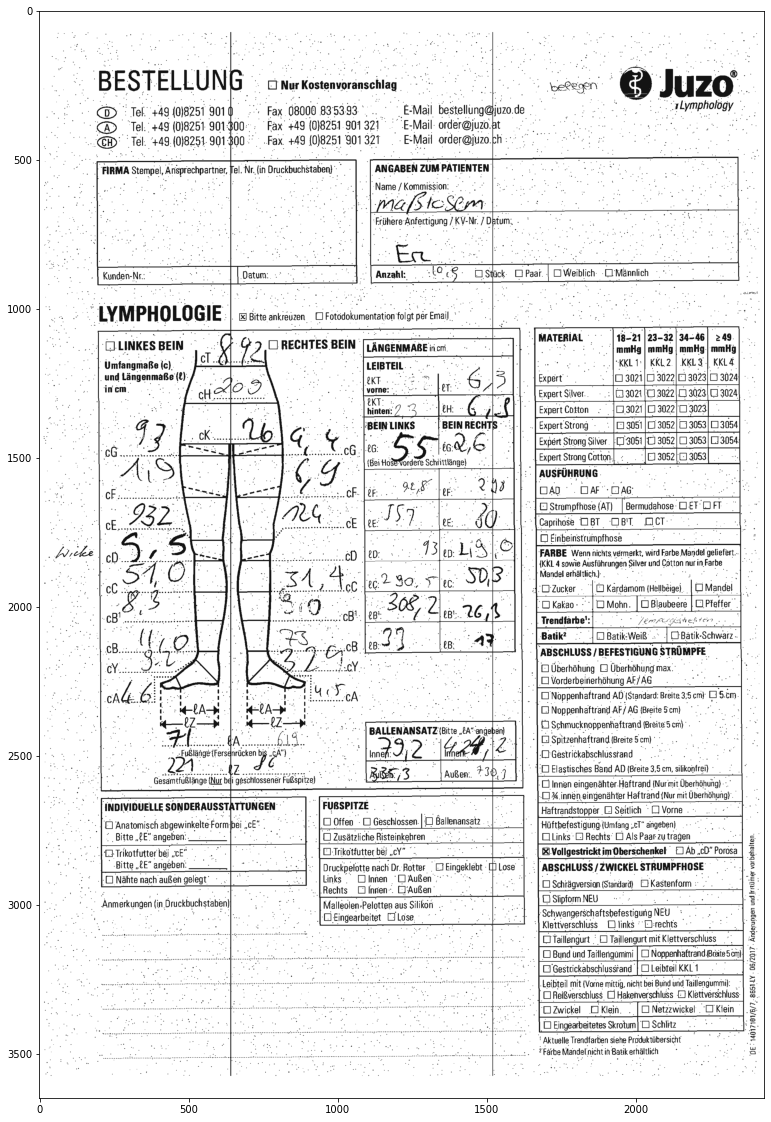

In [23]:
plt.figure(figsize=(30,20))
plt.imshow(full_noisy_image, cmap="gray")

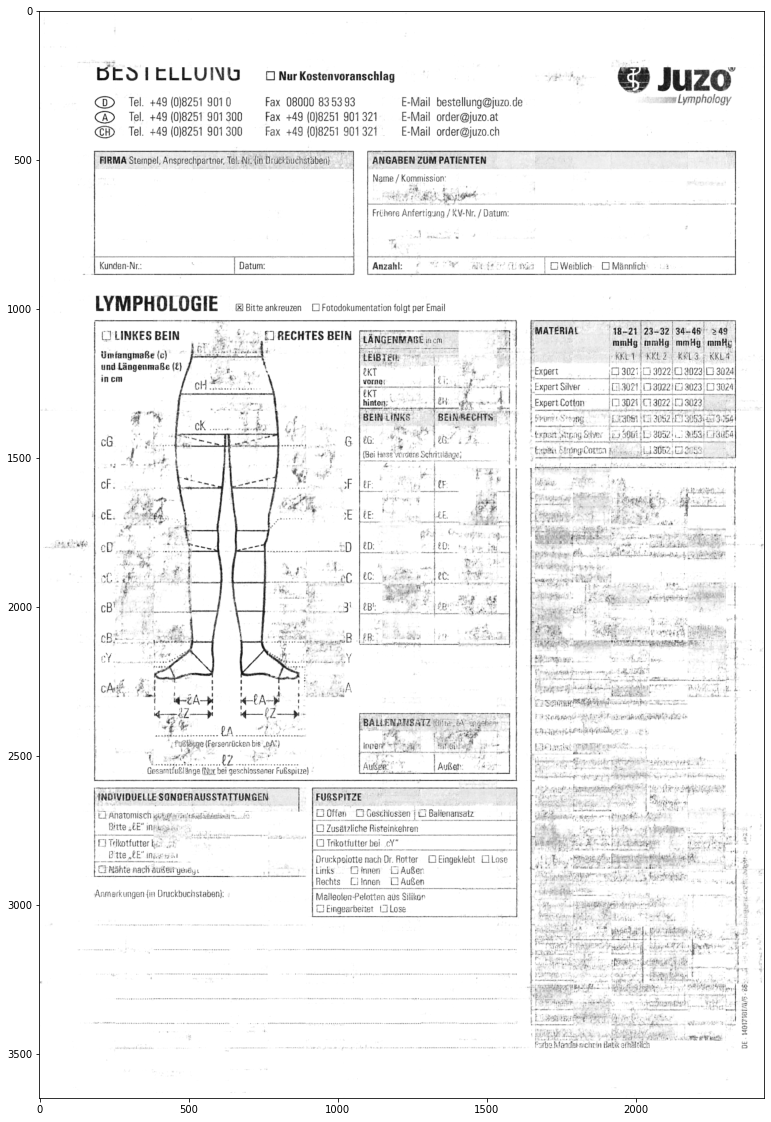

In [24]:
plt.figure(figsize=(30,20))
plt.imshow(full_clean_image, cmap="gray")